In [3]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import librosa
from librosa import display

import glob
import random

import numpy as np

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import pickle

In [ ]:
#READING WAV FILENAMES FROM CSV

data_dir='C:/Users/ashwin.s/Documents/Urban Sound Classification/Data' 
train = pd.read_csv(os.path.join(data_dir, 'train_1.csv'))

train.Class.value_counts(normalize=True)

In [ ]:
#FEATURE EXTRACTION MFCC,CHROMA,MEL,TONNETZ,CONTRAST FOR TRAINING FILES

import numpy as np

def parser(row):
    filename=os.path.join(data_dir,'Train',str(row['ID'])+'.wav')
    
    try:
        X,sr=librosa.load(filename) #try res_type=kaiser_fast
        stdt_amp=np.std(X)
        mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sr,n_mfcc=20).T,axis=0) #(mfccs,chroma,mel,contrast,tonnetz
        chroma = np.mean(librosa.feature.chroma_stft(y=X, sr=sr).T,axis=0)
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sr).T,axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=X, sr=sr).T,axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=X, sr=sr).T,axis=0)
        
    except Exception as e:
        print("Error encountered while extracting file: ",e,filename)
        return None , None
    
    feature = np.hstack(([stdt_amp],mfccs,chroma,mel,contrast,tonnetz))
    #feature =np.hstack([mfccs,chroma])
    #feature = mfccs
    label=row.Class
    
    return pd.Series([feature,label])

In [ ]:
#CALLING PARSER AND STORING THE FEATURES EXTRACTED IN PICKLE FILE FOR REPEATED USE

temp=train.apply(parser,axis=1)
temp.columns = ['feature','label']

temp.to_csv('C:/Users/ashwin.s/Documents/Urban Sound Classification/Data/features174.csv')

X=np.array(temp.feature.tolist())
Y=np.array(temp.label.tolist())

print(X.shape)
      


with open('X_sd.pickle', 'wb') as handle:
     pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('Y.pickle', 'wb') as handle:
     pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [4]:

with open('X.pickle','rb') as handle:
     X=pickle.load(handle)
with open('Y.pickle','rb') as handle:
     Y=pickle.load(handle)

#NORMALIZE FEATURES

mn=np.mean(X,axis=0)
X-=mn
sd=np.std(X,axis=0)
X/=sd
print(Y[10])

#ONE HOT ENCODE THE LABELS

lb=LabelEncoder();

Y=np_utils.to_categorical(lb.fit_transform(Y))
print(Y[10],Y.shape,X.shape)


engine_idling
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] (5435, 10) (5435, 193)


In [49]:
#KERAS MODEL

from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn import metrics

num_labels=Y.shape[1]
filter_size=2

earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')


model=Sequential()

model.add(Dense(193, input_shape=(193,)))
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(400)) #approx. 2 * input_dim
model.add(Activation('relu'))
model.add(Dropout(0.5)) #remove and check

model.add(Dense(400)) #approx. half of previous layer
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='Adam') #optimiser 'adam/adamax'


history=model.fit(X,Y,batch_size=24,epochs=60,validation_split=0.1,verbose=2) #epochs

Train on 4891 samples, validate on 544 samples
Epoch 1/60
 - 2s - loss: 1.4226 - acc: 0.5285 - val_loss: 0.7922 - val_acc: 0.7353
Epoch 2/60
 - 1s - loss: 0.7287 - acc: 0.7778 - val_loss: 0.5614 - val_acc: 0.8235
Epoch 3/60
 - 1s - loss: 0.4992 - acc: 0.8401 - val_loss: 0.5382 - val_acc: 0.8309
Epoch 4/60
 - 1s - loss: 0.3654 - acc: 0.8790 - val_loss: 0.4055 - val_acc: 0.8732
Epoch 5/60
 - 1s - loss: 0.2773 - acc: 0.9147 - val_loss: 0.3954 - val_acc: 0.8732
Epoch 6/60
 - 1s - loss: 0.2379 - acc: 0.9219 - val_loss: 0.3578 - val_acc: 0.9173
Epoch 7/60
 - 1s - loss: 0.2109 - acc: 0.9336 - val_loss: 0.3300 - val_acc: 0.9081
Epoch 8/60
 - 1s - loss: 0.1568 - acc: 0.9538 - val_loss: 0.3750 - val_acc: 0.9099
Epoch 9/60
 - 1s - loss: 0.2240 - acc: 0.9368 - val_loss: 0.2933 - val_acc: 0.9081
Epoch 10/60
 - 1s - loss: 0.2047 - acc: 0.9505 - val_loss: 0.2796 - val_acc: 0.9320
Epoch 11/60
 - 1s - loss: 0.1683 - acc: 0.9571 - val_loss: 0.3557 - val_acc: 0.9044
Epoch 12/60
 - 1s - loss: 0.1472 - acc

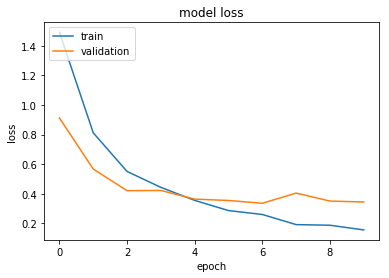

In [43]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [40]:
#FEATURES EXTRACTED FOR TEST FILES

data_dir='C:/Users/ashwin.s/Documents/Urban Sound Classification/Data' 

test = pd.read_csv(os.path.join(data_dir, 'test_1.csv'))
print(test.ID[0])

def parser2(row):
    filename=os.path.join(data_dir,'Test',str(row['ID'])+'.wav')
    
    try:
        X,sr=librosa.load(filename) #try res_type=kaiser_fast
        stdt_amp=np.std(X)
        mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sr,n_mfcc=20).T,axis=0) #(mfccs,chroma,mel,contrast,tonnetz
        chroma = np.mean(librosa.feature.chroma_stft(y=X, sr=sr).T,axis=0)
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sr).T,axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=X, sr=sr).T,axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=X, sr=sr).T,axis=0)
    except Exception as e:
        print("Error encountered while extracting file: ",filename,e)
        return None , None
    
    feature = np.hstack(([stdt_amp],mfccs,chroma,mel,contrast,tonnetz))
    #feature=mfccs
    
    
    i=row['ID']
    
    return pd.Series([i,feature])

temp2=test.apply(parser2,axis=1)
temp2.columns = ['ID','feature']

test_ID=np.array(temp2.ID.tolist())
test_features=np.array(temp2.feature.tolist())

with open('test_ID.pickle', 'wb') as handle:
     pickle.dump(test_ID, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
with open('test_sd_features.pickle', 'wb') as handle:
     pickle.dump(test_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

5


KeyboardInterrupt: 

In [44]:
with open('test_ID.pickle','rb') as handle:
     test_ID=pickle.load(handle)
with open('test_features.pickle','rb') as handle:
     test_features=pickle.load(handle)

print("Previous min max:", np.min(test_features[:][0]) , np.max(test_features[:][0]) )



mn=np.mean( test_features ,axis=0)
test_features-=mn
sd=np.std( test_features ,axis=0)
test_features/=sd

print("After normalization:", np.min(test_features[:][0]) , np.max(test_features[:][0]))
print(test_features.shape)

Previous min max: -67.53523597383956 36.240203060621994
After normalization: -1.924966252741764 9.496510995603572
(3297, 193)


In [45]:
#PREDICTION

print( test_features.shape )
result=model.predict( test_features )
result=result.argmax(axis=-1)

d={
    0:'air_conditioner',
    1:'car_horn',
    2:'children_playing',
    3:'dog_bark',
    4:'drilling',
    5:'engine_idling',
    6:'gun_shot',
    7:'jackhammer',
    8:'siren',
    9:'street_music',
}



(3297, 193)


In [46]:
#OBTAINING CLASS LABEL FROM PREDICTIONS

resultL=[]
print(result.shape,type(result))
for i in range(len(result)):
    resultL.append(d[result[i]])


temp2 = pd.DataFrame(
    {
     'Class': resultL,
     'ID': test_ID,
    })

temp2.to_csv('C:/Users/ashwin.s/Documents/Urban Sound Classification/Data/result_DNN.csv',index=False)


(3297,) <class 'numpy.ndarray'>
